<a href="https://colab.research.google.com/github/matthiasplum/masterclass_CR_ML_module/blob/main/IceCube_MasterClass_Cosmic_Ray_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to a Cosmic Ray Masterclass Module:
# Study Cosmic Rays with Machine Learning at the IceCube Neutrino Observatory

Cosmic rays include particles such as electrons, protons, and heavier nuclei. Their sources are not yet known, but we expect them to be both galactic and extragalactic. The energy spectrum of cosmic rays, which is how the rate changes with increasing energy, has been measured by many detectors, including IceTop. Extragalactic sources are expected to be more abundant as energy increases and to be the only ones responsible for very high-energy cosmic rays.

These cosmic messengers provide us with crucial insights into some of the most enigmatic phenomena in the universe, including the mysterious origins of cosmic rays themselves, the behavior of extreme astrophysical objects like black holes and supernovae, and the nature of dark matter and dark energy.

The IceCube Neutrino Observatory is an extraordinary facility located at the South Pole. It is a cubic kilometer of ice embedded with thousands of light sensors, buried deep beneath the Antarctic surface. Using these sensors, IceCube detects neutrinos, elusive subatomic particles produced by cosmic ray interactions, providing astronomers with a unique window into the high-energy universe. IceCube is complemented by the surface detector array IceTop, which utilizes an array of 1 square kilometer and measures cosmic rays in the energy range from about 100 TeV to 1 EeV, which happens to be the region of the transition from galactic to extragalactic cosmic rays.

In this module, we leverage the power of machine learning to delve deeper into the cosmic ray phenomena observed by IceCube and IceTop and showcase the methods to determine the mass composition of those particles.

 Machine learning, a branch of artificial intelligence, equips us with powerful tools to analyze complex datasets, recognize patterns, and make predictions. By applying machine learning techniques, we aim to uncover hidden insights, identify novel astrophysical sources, and enhance our understanding of cosmic ray physics.

**Only synthetic data are used in this module, but the analysis techniques are the ones we are using all the time.**

[More Information about Cosmic Rays and IceTop.](https://masterclass.icecube.wisc.edu/en/icetop-and-cosmic-rays/measuring-cosmic-rays/)

More information about the real analysis and the full scientific paper can be found here:

[Cosmic Ray Spectrum and Composition from PeV to EeV Using 3 Years of Data From IceTop and IceCube](https://arxiv.org/abs/1906.04317)


<p align="center">
<img src="https://masterclass.icecube.wisc.edu/wp-content/uploads/aboutcr-2.png" width="300">
</p>
Energy spectrum of cosmic rays. The energy unit, the electronvolt (eV), is used by physicists to measure the energy and mass of relativistic particles. A typical chemical reaction happens in the eV energy regime, while nuclear reactions happen in the MeV (a million eV) range. The most powerful particle accelerator on Earth, the LHC, accelerates particles up to a few TeV (a million MeV). Cosmic rays reach energies above hundreds of EeV (a million TeV). Image: http://bit.ly/17gvx8C
<p align="center">
<img src="https://masterclass.icecube.wisc.edu/wp-content/uploads/measuring-shower.png" width="300" />
<img src="https://user-web.icecube.wisc.edu/~mplum/coincident.png" width="200" />
</p>
(left) A cosmic-ray shower reaches IceTop.
(right) A 'coincident' cosmic ray event was measured in IceTop and IceCube simultaniously.


In [1]:
# @title Import necessary libraries
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import powerlaw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback

In [2]:
#Specify Detector capabilities and energy spectrum index
energy_min = 10**6
energy_max = 10**9
zenith_min_deg = 0.
zenith_max_deg = 60.
spectral_index = -2.7 #Energy spectrum power law index

In [3]:
# @title Load helper functions
#Define helper functions

class TimePerEpochCallback(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.times.append(epoch_time)
        if logs is not None:
            logs['time_per_epoch'] = epoch_time

def plot_loghist(x, bins, ax):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    ax.hist(x, bins=logbins,alpha=0.5)
    ax.set_xscale('log')

def generate_power_law_data(num_events, energy_min, energy_max, spectral_index):
    # Generate uniform random numbers
    u = np.random.rand(num_events)

    # Convert uniform random numbers to follow power-law distribution
    energy = (energy_max**(spectral_index + 1) - energy_min**(spectral_index + 1)) * u + energy_min**(spectral_index + 1)
    energy = energy**(1/(spectral_index + 1))
    return energy

def gaussian_random_with_increasing_mean(energy,start_mean=800, std_deviation=1.0, slope=0.05):
    # Calculate the mean as a linear function of energy
    mean = start_mean*(1 + slope*(np.log10(energy)-np.log10(energy_min)))  # Example linear relation, adjust as needed

    # Generate a Gaussian random number with the calculated mean and provided standard deviation
    return np.random.normal(mean, std_deviation)


def generate_cosmic_ray_labeled_data(n_events, particle_type):
    #Generate Type label
    ptype = [particle_type] * n_events

    # Generate energies following a power-law distribution
    energy = generate_power_law_data(n_events, energy_min, energy_max, spectral_index)

    # Generate zenith angles uniformly in arccos between zenith_min_deg and zenith_max_deg
    # Convert degrees to radians
    zenith_min_rad = np.radians(zenith_min_deg)
    zenith_max_rad = np.radians(zenith_max_deg)

    # Generate uniformly distributed samples in the cosine of the angle
    cos_theta_samples = np.random.uniform(np.cos(zenith_max_rad), np.cos(zenith_min_rad), n_events)

    # Convert back to zenith angles
    zenith_angles = np.arccos(cos_theta_samples)

    # Generate air shower maximum
    xmax = []
    for i in range(n_events):
      if particle_type =='proton':
        xmax.append(gaussian_random_with_increasing_mean(energy[i],start_mean=900,std_deviation=50))
      else:
        xmax.append(gaussian_random_with_increasing_mean(energy[i],start_mean=850,std_deviation=40))

    #xmax = np.random.normal(loc=800, scale=50, size=n_events)

    # Generate high energy muon number
    muon_number = []
    for i in range(n_events):
      if particle_type =='proton':
        muon_number.append(gaussian_random_with_increasing_mean(energy[i],start_mean=11,std_deviation=3,slope=0.4))
      else:
        muon_number.append(gaussian_random_with_increasing_mean(energy[i],start_mean=13,std_deviation=2,slope=0.6))

    # Create panda DataFrame
    cosmic_ray_data = pd.DataFrame({
        'Type': ptype,
        'Energy': energy,
        'Log10Energy': np.log10(energy),
        'Zenith': zenith_angles,
        'MuonNumber': muon_number,
        'Xmax': xmax
    })

    return cosmic_ray_data

In [4]:
#Define the size of your data sets
num_events = 10000

In [5]:
# @title Create the syntetic data sets
#Create labeled data sets for proton and iron cosmic rays
df_proton = generate_cosmic_ray_labeled_data(num_events,'proton')
df_iron = generate_cosmic_ray_labeled_data(num_events,'iron')

#Combine labeled datasets to your analysis data set
data = pd.concat([df_proton, df_iron], ignore_index=True)

In [6]:
# Explore the dataset
print(data.head())  # Check the first few rows
print(" ")
print(data.info())  # Get information about columns and data types
#print(data.describe())  # Statistical summary of numerical columns

     Type        Energy  Log10Energy    Zenith  MuonNumber        Xmax
0  proton  2.355021e+06     6.371995  0.857369   11.232685  872.998342
1  proton  1.776680e+06     6.249609  0.592771   13.076763  912.099448
2  proton  1.351096e+06     6.130686  0.677439   12.072658  932.463410
3  proton  1.077581e+06     6.032450  0.817363    8.540474  896.620875
4  proton  1.085573e+07     7.035659  0.527954   14.565790  923.064083
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         20000 non-null  object 
 1   Energy       20000 non-null  float64
 2   Log10Energy  20000 non-null  float64
 3   Zenith       20000 non-null  float64
 4   MuonNumber   20000 non-null  float64
 5   Xmax         20000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 937.6+ KB
None


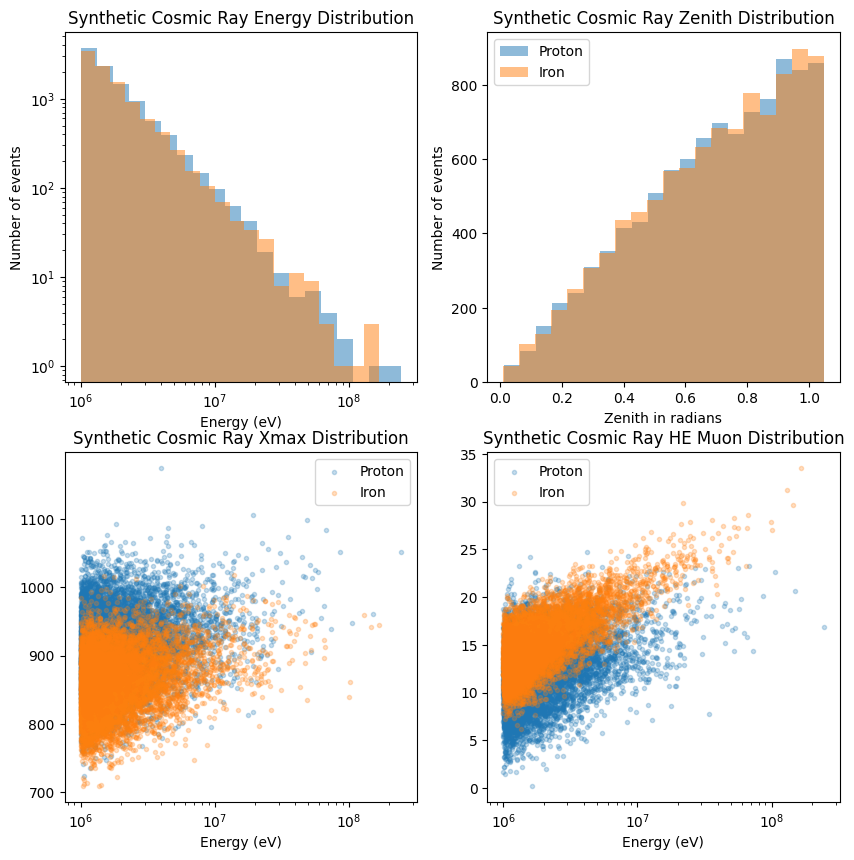

In [18]:
# @title Plot the synthetic data set
# Plotting the measured distributions
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(10, 10))

plot_loghist(df_proton['Energy'],20,ax1)
plot_loghist(df_iron['Energy'],20,ax1)

ax1.set_yscale('log')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Number of events')
ax1.set_title('Synthetic Cosmic Ray Energy Distribution')

ax2.hist(df_proton['Zenith'],20,alpha=0.5,label='Proton')
ax2.hist(df_iron['Zenith'],20,alpha=0.5,label='Iron')

ax2.legend()
ax2.set_xlabel('Zenith in radians')
ax2.set_ylabel('Number of events')
ax2.set_title('Synthetic Cosmic Ray Zenith Distribution')

ax3.scatter(df_proton['Energy'],df_proton['Xmax'],alpha=0.25,marker='.',label='Proton')
ax3.scatter(df_iron['Energy'],df_iron['Xmax'],alpha=0.25,marker='.',label='Iron')

ax3.legend()
ax3.set_title('Synthetic Cosmic Ray Xmax Distribution')
ax3.set_xscale('log')
ax3.set_xlabel('Energy (eV)')

ax4.scatter(df_proton['Energy'],df_proton['MuonNumber'],alpha=0.25,marker='.',label='Proton')
ax4.scatter(df_iron['Energy'],df_iron['MuonNumber'],alpha=0.25,marker='.',label='Iron')

ax4.legend()
ax4.set_title('Synthetic Cosmic Ray HE Muon Distribution')
ax4.set_xlabel('Energy (eV)')
ax4.set_xscale('log')

plt.show()

**Are all observables carrying information about the primary mass?**

# Preprocessing of data
Preprocessing of data involves getting your data ready for machine learning algorithms by cleaning, transforming, and organizing it in a format that the model can understand and learn from effectively.

Encoding Categorical Variables:

* If your dataset contains categorical variables (like colors, categories, etc.), you need to convert them into a numerical format because most machine learning algorithms only understand numerical data. One common method is Label Encoding, which assigns a unique number to each category.

Splitting the Data:
* Divide your dataset into two subsets: a training set and a testing set. The training set is used to train the model, while the testing set is used to evaluate its performance. This helps to assess how well the model will generalize to new, unseen data.

Feature Scaling:
* It's important to scale your features to a similar range to prevent some features from dominating others. Standardization and normalization are two common techniques used for feature scaling. Standardization scales the data to have a mean of 0 and a standard deviation of 1, while normalization scales the data to a range between 0 and 1.




In [8]:
# Preprocessing of the data

# Encode categorical variables if any. In this case transform the name of the particle into a number.
label_encoder = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data['Encoded_'+column] = label_encoder.fit_transform(data[column])

#Drop unused columns
data = data.drop(columns=['Energy','Type'])

# Split the dataset into features and target variable
X = data.drop(['Encoded_Type'], axis=1)  # Features
y = data['Encoded_Type']                 # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling if required
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# @title The following code is used to save your training tries... ONLY RUN THIS ONCE!!!!
#This is used to save your training tries... ONLY RUN THIS ONCE!!!!
training_histories = []

# Tuning neural network parameter

These are some of the neural network parameters that you can tune and test how they effect your training.

Loss Function:

* It's a measure of how well the model is performing during training.
* Think of it as a way to calculate how "wrong" the model's predictions are compared to the actual values.
* The goal during training is to minimize this "wrongness" or loss.
* Common loss functions include Mean Squared Error (MSE) for regression tasks and Binary Crossentropy or Categorical Crossentropy for classification tasks.

Batch Size:

* It's the number of samples used in one iteration of training.
* Imagine your dataset is a big book. Instead of reading the entire book at once, you read it page by page. Each page represents a batch.
* Using smaller batch sizes helps in faster training and better utilization of memory resources, especially for large datasets.

Number of Epochs:

* An epoch is one complete pass through the entire training dataset.
* The number of epochs defines how many times the model will see the entire dataset during training.
* Just like reading the same book multiple times to remember it better, training for multiple epochs helps the model learn patterns in the data more effectively.
* However, training for too many epochs can lead to overfitting, where the model memorizes the training data instead of learning general patterns.

Dropout:

* It's a regularization technique used to prevent overfitting in neural networks.
* During training, randomly selected neurons (along with their connections) are temporarily ignored or "dropped out."
* It's like temporarily removing certain parts of your brain while studying to ensure that you don't rely too much on specific parts and learn more robustly.
* Dropout helps in improving the generalization ability of the model by forcing it to learn redundant representations of the data, making it more robust to noise and variations.

Please play around with those values!

In [10]:
loss_function = 'binary_crossentropy' #'binary_crossentropy' or 'CategoricalHinge'
batchsize = 256 # e.g. 64, 128 or 256
num_epoch = 30 # e.g. 10, 20 or 30
dropout = 0.1 # e.g. 0.1, 0.2 or 0.9

The following cell is running the training and testing of the neural network. Depending on the chosen parameters and the model architecture this can take seconds to minutes to complete.

**The model architecture can be changed if you want to!**

In [11]:
# Define the neural network model
model = Sequential([
    Dense(18, activation='relu', input_shape=(X_train_scaled.shape[1],)),# First Layer of network
    Dropout(dropout),
    Dense(36, activation='relu'),# Second Layer of network
    Dropout(dropout),
    Dense(1, activation='sigmoid')
])

time_callback = TimePerEpochCallback()

# Compile the model
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

# Visualize the model architecture
#plot_model(model, show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(X_train_scaled, y_train,
                    epochs=num_epoch,
                    batch_size=batchsize,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[time_callback]
                    )
training_histories.append([history,loss_function,batchsize,dropout,num_epoch])

print(" ")
# Model evaluation
# Predictions on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:")
#print(conf_matrix)

Epoch 1/30
44/44 [==============================] - 2s 13ms/step - loss: 0.6516 - accuracy: 0.6288 - val_loss: 0.5775 - val_accuracy: 0.7604 - time_per_epoch: 2.4065
Epoch 2/30
44/44 [==============================] - 0s 6ms/step - loss: 0.5285 - accuracy: 0.7686 - val_loss: 0.4881 - val_accuracy: 0.7793 - time_per_epoch: 0.2512
Epoch 3/30
44/44 [==============================] - 0s 6ms/step - loss: 0.4733 - accuracy: 0.7779 - val_loss: 0.4613 - val_accuracy: 0.7871 - time_per_epoch: 0.2754
Epoch 4/30
44/44 [==============================] - 0s 5ms/step - loss: 0.4620 - accuracy: 0.7835 - val_loss: 0.4560 - val_accuracy: 0.7889 - time_per_epoch: 0.2089
Epoch 5/30
44/44 [==============================] - 0s 5ms/step - loss: 0.4568 - accuracy: 0.7856 - val_loss: 0.4534 - val_accuracy: 0.7904 - time_per_epoch: 0.2392
Epoch 6/30
44/44 [==============================] - 0s 7ms/step - loss: 0.4525 - accuracy: 0.7909 - val_loss: 0.4518 - val_accuracy: 0.7925 - time_per_epoch: 0.3111
Epoch 7/3

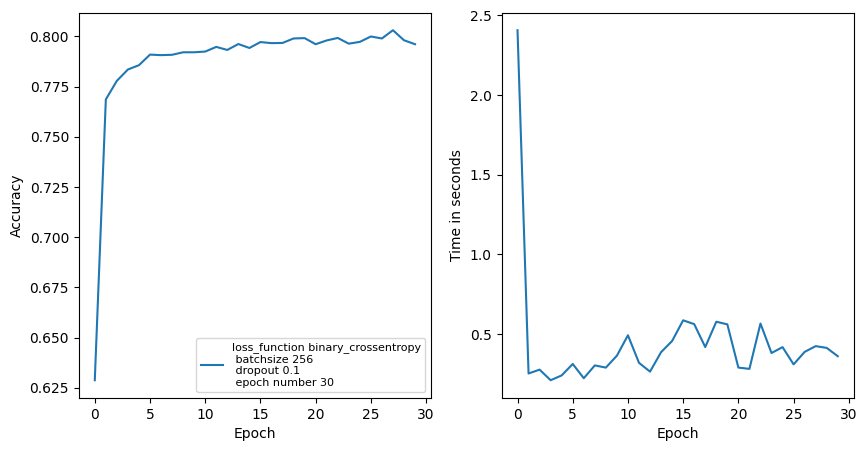

In [12]:
# @title Plot and compare your training with each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for i, hist in enumerate(training_histories):
  # Plot training history
  ax1.plot(hist[0].history['accuracy'], label='loss_function '+ hist[1] +'\n batchsize ' + str(hist[2]) + '\n dropout ' + str(hist[3]) + '\n epoch number ' + str(hist[4]))
  #plt.plot(hist.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(prop={'size': 8})
for i, hist in enumerate(training_histories):
  ax2.plot(hist[0].history['time_per_epoch'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Time in seconds')

plt.show()

A confusion matrix is a table used in classification tasks to evaluate how well a model is performing in terms of predicting classes. It helps us understand where the model is getting confused or making errors.

Imagine you have a binary classification task, where you're trying to predict whether a cosmic ray event is proton or iron.

* True Positive (TP): The model correctly predicted a proton as a proton.
* False Negative (FN): The model incorrectly predicted a proton as iron.
* False Positive (FP): The model incorrectly predicted iron as a proton.
* True Negative (TN): The model correctly predicted iron as iron.

Interpretation:
* You want the majority of your predictions to fall on the diagonal (True Positive and True Negative) because those are correct predictions.
* A large number of False Positives and False Negatives indicates areas where the model is making mistakes and may need improvement.
* You can calculate more metrics like accuracy, precision, recall, and F1-score using the values from the confusion matrix to evaluate the model's performance further.

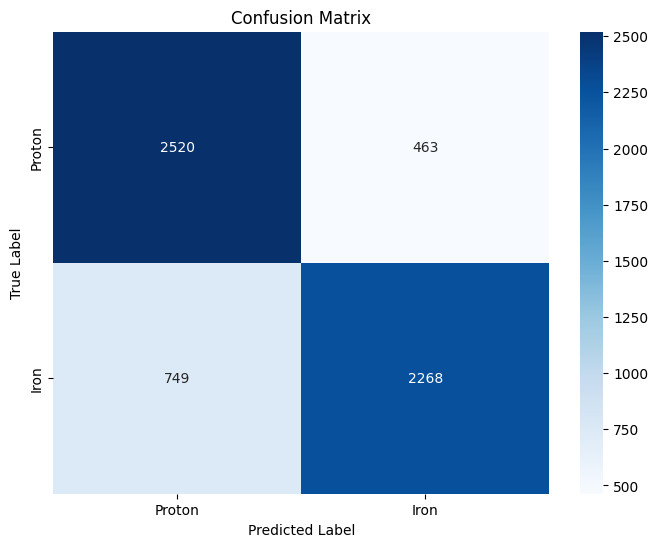

In [13]:
# @title Plot the confusion matrix for your last training
classes = ['Proton', 'Iron']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()